# Highly Adaptive Models Comparison Project

## Overview

This project aims to empirically compare the performance of two statistical models: the Highly Adaptive Lasso (HAL) and Highly Adaptive Ridge (HAR) in high-dimensional data analysis. Both models are variants of regularization techniques used in regression and machine learning to prevent overfitting by adding a penalty to the loss function. The focus is on evaluating these models in terms of computational efficiency, prediction accuracy, and the effectiveness of regularization under various conditions.

## Goals

1. **Empirical Comparison**: Conduct a thorough empirical comparison between HAL and HAR models to assess their performance on high-dimensional datasets.
2. **Computation Time**: Evaluate and compare the computation times required by each model to fit the data, providing insights into their efficiency.
3. **Prediction Accuracy**: Use metrics such as Mean Squared Error (MSE) to compare the prediction accuracy of the models across different dataset sizes and conditions.
4. **Regularization Effectiveness**: Examine how cross-validation techniques control the regularization parameters in both models, focusing on the L1 norm control in HAR despite its explicit use of L2 regularization.
5. **Scalability**: Assess how each model scales with increasing data dimensions, offering insights into their applicability to real-world, high-dimensional datasets.

## Methodology

The project utilizes a simulation-based approach to generate synthetic datasets with controllable features such as the number of samples, number of features, and the level of noise. The simulation involves:

- Generating datasets using the DGP classes in `generators.py`.
- Fitting both HAL and HAR models to these datasets.
- Evaluating model performance using cross-validation and calculating MSE on a test set.
- Repeating the process for various dataset sizes to gather comprehensive performance data.

## Results Analysis

The simulation results will be analyzed and visualized to compare the computation time and MSE of HAL and HAR models. This analysis aims to provide a clear understanding of each model's strengths and limitations, particularly regarding their efficiency and accuracy in handling high-dimensional data.



# TODOs

- split up for each dgp
- 

# 1.0) Setup


In [1]:
from highly_adaptive_lasso import HAL
from highly_adaptive_ridge import HAR
import numpy as np
from data_generators import DataGenerator, SmoothDataGenerator, JumpDataGenerator, SinusoidalDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd 
import matplotlib.pyplot as plt

/var/folders/ym/50f9gfp105v6t4xqyx661zb80000gn/T/ipykernel_41910/4110712141.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Let's generate some data!

In [2]:
# Performance metric R^2 as defined in HAL paper 
def calculate_r_squared(Y, Y_hat):
    ss_res = np.sum((Y - Y_hat) ** 2)
    ss_tot = np.sum((Y - np.mean(Y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# 2.0: Fixed N, varying d $ \in $ {1, 3, 5}

For each d, averaging training time, MSE, and $ R^2 $ across smooth, jump, and sinusoidal data. 

In [6]:
import time

num_samples = 100
d_sizes = [1, 3, 5]
dgp_list = [SmoothDataGenerator, JumpDataGenerator, SinusoidalDataGenerator]

for dgp in dgp_list:
    print(f'Running for {dgp.__name__}')
    for d in d_sizes:
        print(f'\t Running for d={d}') 

        X, Y = dgp.generate_data(num_samples, d)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9, random_state=42)

        # HAL
        hal = HAL()
        start_time = time.time()
        hal.fit(X_train, Y_train)
        hal_time = time.time() - start_time
        hal_pred = hal.predict(X_test)
        hal_mse = np.mean((hal_pred - Y_test)**2)

        # HAR
        har = HAR()
        start_time = time.time()
        har.fit(X_train, Y_train)
        har_time = time.time() - start_time
        har_pred = har.predict(X_test)
        har_mse = np.mean((har_pred - Y_test)**2)

        # display training time, MSE and R^2 for both models in a table
        print(f'\t\t HAL \t\t HAR')
        print(f'\t Time: \t {round(hal_time, 5)} \t {round(har_time, 5)}')
        print(f'\t MSE: \t {round(hal_mse, 5)} \t {round(har_mse, 5)}')
        print(f'\t R^2: \t {round(calculate_r_squared(Y_test, hal_pred), 5)} \t {round(calculate_r_squared(Y_test, har_pred), 5)}')

        print("-"*50)


Running for SmoothDataGenerator
	 Running for d=1
		 HAL 		 HAR
	 Time: 	 0.01243 	 0.00106
	 MSE: 	 1.29997 	 1.28963
	 R^2: 	 0.07117 	 0.07856
--------------------------------------------------
	 Running for d=3
		 HAL 		 HAR
	 Time: 	 0.01127 	 0.00047
	 MSE: 	 2.61249 	 2.44721
	 R^2: 	 -0.00503 	 0.05856
--------------------------------------------------
	 Running for d=5
		 HAL 		 HAR
	 Time: 	 0.01666 	 0.00743
	 MSE: 	 8.22785 	 5.79829
	 R^2: 	 -0.36369 	 0.03899
--------------------------------------------------
Running for JumpDataGenerator
	 Running for d=1
		 HAL 		 HAR
	 Time: 	 0.01544 	 0.00044
	 MSE: 	 1.09853 	 1.16686
	 R^2: 	 -0.19928 	 -0.27387
--------------------------------------------------
	 Running for d=3
		 HAL 		 HAR
	 Time: 	 0.02141 	 0.00727
	 MSE: 	 4.28742 	 4.03369
	 R^2: 	 -0.6679 	 -0.56919
--------------------------------------------------
	 Running for d=5
		 HAL 		 HAR
	 Time: 	 0.02687 	 0.0005
	 MSE: 	 6.92057 	 5.24155
	 R^2: 	 -0.60445 	 -0

# 3.0: Fixed d, varying N 

In [5]:
import time
import matplotlib.pyplot as plt

# Sample sizes to test
# sample_sizes = [100, 500, 1000, 2000]
d = 3
sample_sizes = [100, 250, 500, 750, 1000]

# Initialize a dictionary to store runtimes
runtimes = {
    'HAL': {d: [] for d in sample_sizes},
    'HAR': {d: [] for d in sample_sizes}
}

# Loop over each DGP
for dgp in dgp_list:
    # Loop over each sample size
    for n in sample_sizes:
        print(f'Running for {dgp.__name__} with sample size: {n}')
        
        # Generate data
        X, Y = dgp.generate_data(n, d)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9, random_state=42)

        # HAL
        hal = HAL()
        start_time = time.time()
        hal.fit(X_train, Y_train)
        hal_time = time.time() - start_time
        runtimes['HAL'][n].append(hal_time)

        # HAR
        har = HAR()
        start_time = time.time()
        har.fit(X_train, Y_train)
        har_time = time.time() - start_time
        runtimes['HAR'][n].append(har_time)

# Now plot the runtimes
for model, data in runtimes.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'Runtime vs Sample Size for {model}, d = {d}')
    plt.xlabel('Sample Size')
    plt.ylabel('Runtime (seconds)')
    sample_sizes_sorted = sorted(data.keys())
    runtimes_avg = [np.mean(data[size]) for size in sample_sizes_sorted]
    plt.plot(sample_sizes_sorted, runtimes_avg, marker='o', label=model)
    plt.legend()
    plt.show()


Running for SmoothDataGenerator with sample size: 100
Running for SmoothDataGenerator with sample size: 250
Running for SmoothDataGenerator with sample size: 500
Running for SmoothDataGenerator with sample size: 750


/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-02, tolerance: 1.740e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-02, tolerance: 1.740e-02
  model = cd_fast.enet_coordinate_descent(


Running for SmoothDataGenerator with sample size: 1000


/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e-02, tolerance: 2.103e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.247e-02, tolerance: 2.103e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Convergen

Running for JumpDataGenerator with sample size: 100
Running for JumpDataGenerator with sample size: 250
Running for JumpDataGenerator with sample size: 500
Running for JumpDataGenerator with sample size: 750
Running for JumpDataGenerator with sample size: 1000


/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.738e-02, tolerance: 3.053e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.933e-02, tolerance: 3.053e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Convergen

Running for SinusoidalDataGenerator with sample size: 100
Running for SinusoidalDataGenerator with sample size: 250
Running for SinusoidalDataGenerator with sample size: 500
Running for SinusoidalDataGenerator with sample size: 750


/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e-02, tolerance: 1.246e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e-02, tolerance: 1.246e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Convergen

Running for SinusoidalDataGenerator with sample size: 1000


/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.867e-02, tolerance: 2.351e-02
  model = cd_fast.enet_coordinate_descent(
/Users/alexhagemeister/.local/share/virtualenvs/Highly_Adaptive_Ridge-awx9OXbz/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e-02, tolerance: 2.351e-02
  model = cd_fast.enet_coordinate_descent(


KeyboardInterrupt: 

In [4]:

# # this displays the alpha values that were used in the LassoCV
# # NOTE: alpha refers to the regularization parameter (?)
# # TODO: Ask Alejandro about this
# alphas = model.lasso.alphas_
# alpha = model.lasso.alpha_

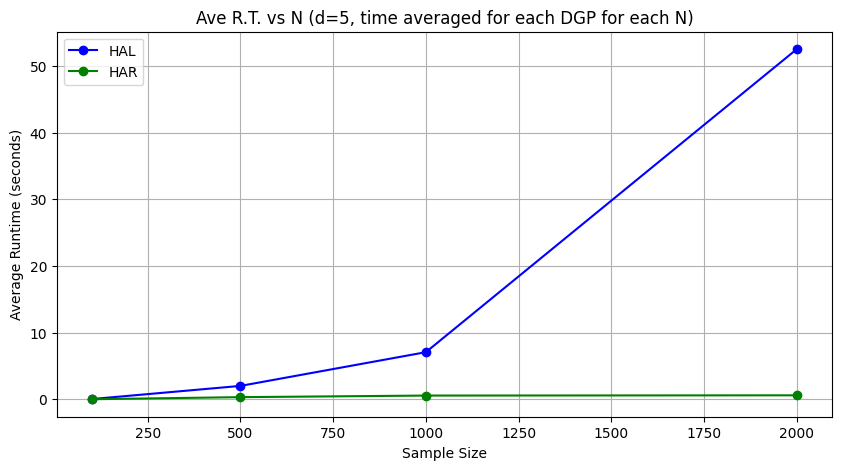

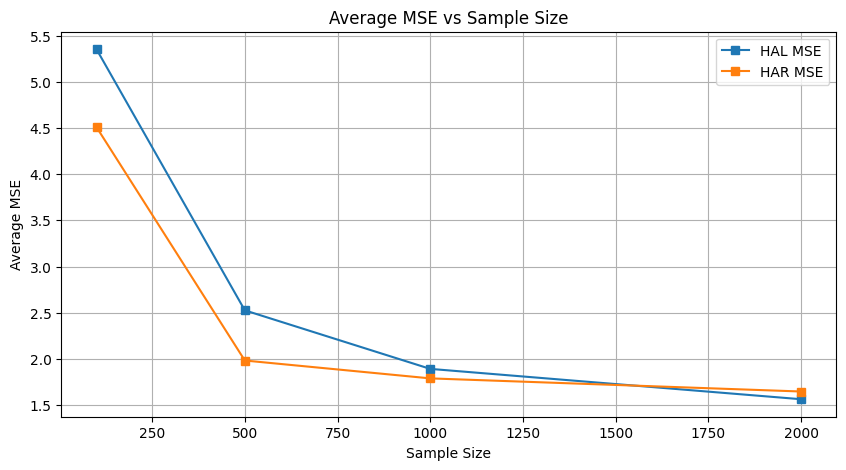

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Sample sizes to test
sample_sizes = [100, 500, 1000, 2000]

# Initialize a dictionary to store runtimes & MSEs for each model
runtimes = {
    'HAL': [],
    'HAR': []
}
mses = {
    'HAL': [],
    'HAR': []
}

# Loop over each sample size
for n in sample_sizes:
    # Initialize accumulators for runtimes and MSEs
    hal_times, har_times = [], []
    hal_mses, har_mses = [], []

    # Loop over each DGP
    for dgp in dgp_list:
        # Generate data
        X, Y = dgp.generate_data(n, max(d_sizes))
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9, random_state=42)

        # Fit HAL for given DGP, N, recording runtime and MSE
        hal = HAL()
        start_time = time.time()
        hal.fit(X_train, Y_train)
        hal_times.append(time.time() - start_time)
        hal_mse = mean_squared_error(Y_test, hal.predict(X_test))
        hal_mses.append(hal_mse)


        # Fit HAr for given DGP, N, recording runtime and MSE
        har = HAR()
        start_time = time.time()
        har.fit(X_train, Y_train)
        har_times.append(time.time() - start_time)
        har_mse = mean_squared_error(Y_test, har.predict(X_test))
        har_mses.append(har_mse)

    # Store the average runtime and MSE for each model across all DGPs
    runtimes['HAL'].append(np.mean(hal_times))
    runtimes['HAR'].append(np.mean(har_times))
    mses['HAL'].append(np.mean(hal_mses))
    mses['HAR'].append(np.mean(har_mses))

# Plot Ave R.T. vs N (d=5, time averaged for each DGP for each N)
plt.figure(figsize=(10, 5))
colors = ['blue', 'green']
model_names = ['HAL', 'HAR']

# Loop through each model and plot with a different color
for i, model in enumerate(model_names):
    plt.plot(sample_sizes, runtimes[model], marker='o', label=model, color=colors[i])

plt.title(f'Ave R.T. vs N (d={5}, time averaged for each DGP for each N)')
plt.xlabel('Sample Size')
plt.ylabel('Average Runtime (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting MSE vs N 
plt.figure(figsize=(10, 5))
for model, errors in mses.items():
    plt.plot(sample_sizes, errors, marker='s', label=f'{model} MSE')

plt.title('Average MSE vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Average MSE')
plt.legend()
plt.grid(True)
plt.show()

Training and evaluation

In [5]:
from sklearn.metrics import mean_squared_error
import time

# Initialize models
hal = HAL() 
har = HAR()  

# Fit models and record computation time
start_time = time.time()
hal.fit(X_train, y_train)
hal_time = time.time() - start_time

start_time = time.time()
har.fit(X_train, y_train)
har_time = time.time() - start_time

# Evaluate models
hal_mse = mean_squared_error(y_test, hal.predict(X_test))
har_mse = mean_squared_error(y_test, har.predict(X_test))

In [6]:
# Display results
print("HAL MSE: ", hal_mse)
print("HAR MSE: ", har_mse)
print("HAL time: ", hal_time)
print("HAR time: ", har_time)


HAL MSE:  1.3248696023454873
HAR MSE:  1.1878823745413873
HAL time:  0.011644124984741211
HAR time:  0.0008082389831542969


In [7]:
# Now, let's try using sklearn make_regression to generate data! 
# This will give me more flexibility in the number of samples, features, etc. without having to modify the DataGenerator class
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

num_samples = 100

# Generate synthetic data using make_regression
X, Y = make_regression(n_samples=num_samples, n_features=3, noise=0.1)

# from data_generator import DataGenerator
# X, Y = DataGenerator.generate_data(num_samples)

test_size = 0.9 # use 90% of the data for training
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

In [8]:
# Fit models and record computation time
start_time = time.time()
hal.fit(X_train, y_train)
hal_time = time.time() - start_time

start_time = time.time()
har.fit(X_train, y_train)
har_time = time.time() - start_time

# Evaluate models
hal_mse = mean_squared_error(y_test, hal.predict(X_test))
har_mse = mean_squared_error(y_test, har.predict(X_test))

In [9]:
# Display results
print("HAL MSE: ", hal_mse)
print("HAR MSE: ", har_mse)
print("HAL time: ", hal_time)
print("HAR time: ", har_time)

HAL MSE:  5512.560510604352
HAR MSE:  3249.1976333066077
HAL time:  0.015147209167480469
HAR time:  0.0006997585296630859
